# Predicting Hospital Readmission for Diabetes Patients

## Objective
Demonstrate an end-to-end machine learning pipeline to predict whether a patient will be readmitted to a hospital after a diabetes diagnosis using data maintained by UCI detailing 10 years of clinical care at U.S. hospitals and integrated delivery networks.

## Table of Contents
* [Data Loading](#data_loading)
* [Data Cleaning & Preprocessing](#data_cleaning)
* [Exploratory Data Analysis (EDA)](#eda)
    * [Expore numeric data](#eda_numeric)
    * [Explore categorical data](#eda_categorical)
* [Feature Engineering](#feature_engineering)
* [Model Training & Evaluation](#model_training)

In [1]:
import io
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

import requests

%matplotlib inline

## Data Loading <a class="anchor" id="data_loading"></a>

In [2]:
# URL of the dataset
url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"

try:
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    response.raise_for_status() # raises error for bad HTTP responses

    print("Download successful! Extracting files...")
    zip_file = zipfile.ZipFile(io.BytesIO(response.content)) # open ZIP in memory

    # list the files
    files_list = zip_file.namelist()
    print("Files contained in ZIP:\n", ", ".join(files_list))

    # create a dictionary to store the files
    files = {}

    for file_name in files_list:
        with zip_file.open(file_name) as f:
            files[file_name] = pd.read_csv(f)

    # assign the DataFrames to variables
    df_diabetes = files.get("diabetic_data.csv")
    df_ids = files.get("IDS_mapping.csv")

except requests.exceptions.RequestException as e:
    print(f"Error downloading dataset: {e}")

    # TODO: Possibly comment out the next three lines
    print("Retrieving from local directory...")
    df_diabetes = pd.read_csv("~/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv")
    df_ids = pd.read_csv("~/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/IDS_mapping.csv")

except zipfile.BadZipFile:
    print("Error processing ZIP file")

except OSError as e:
    print(f"Error opening file: {e}")

except KeyError as e:
    print(f"Error retrieving file: {e}")

Download successful! Extracting files...
Files contained in ZIP:
 diabetic_data.csv, IDS_mapping.csv


## Data Cleaning & Preprocessing <a class="anchor" id="data_cleaning"></a>

In [3]:
# prepare the IDs DF for merging
df_ids.dropna(inplace=True)
df_filtered_ids = df_ids[df_ids["admission_type_id"].str.isdigit()].copy()
df_grouped_ids = df_filtered_ids.groupby("admission_type_id")["description"].apply(lambda x: " | ".join(x)).reset_index()

# prepare the diabetes DF for merging
df_diabetes["admission_type_id"] = df_diabetes["admission_type_id"].astype(str)

# merge the DFs
df = df_diabetes.merge(df_grouped_ids, how="left", on="admission_type_id")

In [4]:
# look at the data types
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [5]:
# cast any identifer columns to an object type
cols_to_convert = df.filter(regex=r"_(?:id|nbr)$").columns
df[cols_to_convert] = df[cols_to_convert].astype(str)

In [6]:
# identify columns using a question mark as a null value
question_mark_cols = ", ".join(df.columns[(df == "?").any()])
print("Columns using \"?\" to signify null values:\n", question_mark_cols)

# replace "?" rows with NaN
df.where(df != "?", np.nan, inplace=True)

Columns using "?" to signify null values:
 race, weight, payer_code, medical_specialty, diag_1, diag_2, diag_3


In [7]:
def display_missing_value_columns(df):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing null statistics.
    """

    # get columns and their missing value counts
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0].reset_index()

    # rename the columns and calculate the percentage of nulls
    missing_values.columns = ["column_name", "null_count"]
    missing_values["null_perc"] = missing_values["null_count"] / df.shape[0]

    # sort the values
    missing_values.sort_values(by="null_perc", ascending=False, inplace=True)

    return missing_values

In [8]:
# create a DF showing missing value statistics
display_missing_value_columns(df)

,column_name,null_count,null_perc
1,weight,98569,0.968585
7,max_glu_serum,96420,0.947468
8,A1Cresult,84748,0.832773
3,medical_specialty,49949,0.490822
2,payer_code,40256,0.395574
0,race,2273,0.022336
6,diag_3,1423,0.013983
5,diag_2,358,0.003518
4,diag_1,21,0.000206


In [9]:
# drop columns with 30% or more values missing
non_na_vals = df.shape[0] - (0.3 * df.shape[0])
df.dropna(thresh=non_na_vals, axis=1, inplace=True)

In [10]:
# check for duplicates
print(f"Total duplicate rows: {df.duplicated().sum()}")
df[df.duplicated()]

Total duplicate rows: 0


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description


In [11]:
def map_icd9_to_category(code):
    """Maps ICD-9 codes to disease categories.

    Args:
        code: A string value representing an ICD-9 code.
    Returns:
        category: A string value representing a disease classification.
    """

    try:
        code = str(code).strip()
        if code.startswith("250"):
            category =  "Diabetes-Related"
        elif code.startswith("E"):
            category =  "Supplementary Classification of External Causes of Injury and Poisoning"
        elif code.startswith("V"):
            category =  "Supplementary Classification of Factors influencing Health Status and Contact with Health Services"

        code = int(float(code))
        if 1 <= code <= 139:
            category =  "Infectious and Parasitic Diseases"
        elif 140 <= code <= 239:
            category =  "Neoplasms"
        elif 240 <= code <= 279:
            category =  "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders"
        elif 280 <= code <= 289:
            category =  "Diseases of the Blood and Blood-forming Organs"
        elif 290 <= code <= 319:
            category =  "Mental Disorders"
        elif 320 <= code <= 389:
            category =  "Diseases of the Nervous System and Sense Organs"
        elif 390 <= code <= 459:
            category =  "Diseases of the Circulatory System"
        elif 460 <= code <= 519:
            category =  "Diseases of the Respiratory System"
        elif 520 <= code <= 579:
            category =  "Diseases of the Digestive System"
        elif 580 <= code <= 629:
            category =  "Diseases of the Genitourinary System"
        elif 630 <= code <= 679:
            category =  "Complications of Pregnancy, Childbirth, and the Puerperium"
        elif 680 <= code <= 709:
            category =  "Diseases of the Skin and Subcutaneous Tissue"
        elif 710 <= code <= 739:
            category =  "Diseases of the Musculoskeletal System and Connective Tissue"
        elif 740 <= code <= 759:
            category =  "Congenital Anomalies"
        elif 760 <= code <= 779:
            category =  "Certain Conditions originating in the Perinatal Period"
        elif 780 <= code <= 799:
            category =  "Symptoms, Signs and Ill-defined Conditions"
        elif 800 <= code <= 999:
            category =  "Injury and Poisoning"
        else:
            category =  "Other"

    except:
        category =  "Other"

    return category

In [12]:
# convert ICD-9 codes to disease categories
df[["disease_class_1", "disease_class_2", "disease_class_3"]] = df[["diag_1", "diag_2", "diag_3"]].apply(lambda col: col.map(map_icd9_to_category, na_action="ignore"))

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Explore numeric data <a class="anchor" id="eda_numeric"></a>

In [13]:
# look at descriptive statistics for numeric columns
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [14]:
def plot_numeric_distributions(df):
    """Generates a grid of boxplots and histograms for numeric columns.

    Args:
        df (pd.DataFrame): A dataset with numeric data.
    """

    # identify numeric columns
    numeric_cols = sorted(df.select_dtypes(include="number").columns)

    # get the number of numeric columns
    num_cols = len(numeric_cols)

    # create a figure and set of subplots
    fig, axes = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side boxplot and histogram for each row
    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, color="mediumvioletred", ax=axes[i, 0])
        axes[i, 0].set_title(f"Boxplot of {col}")

        sns.histplot(data=df, x=col, color="lightcoral", ax=axes[i, 1])
        axes[i, 1].set_title(f"Histogram of {col}")

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()

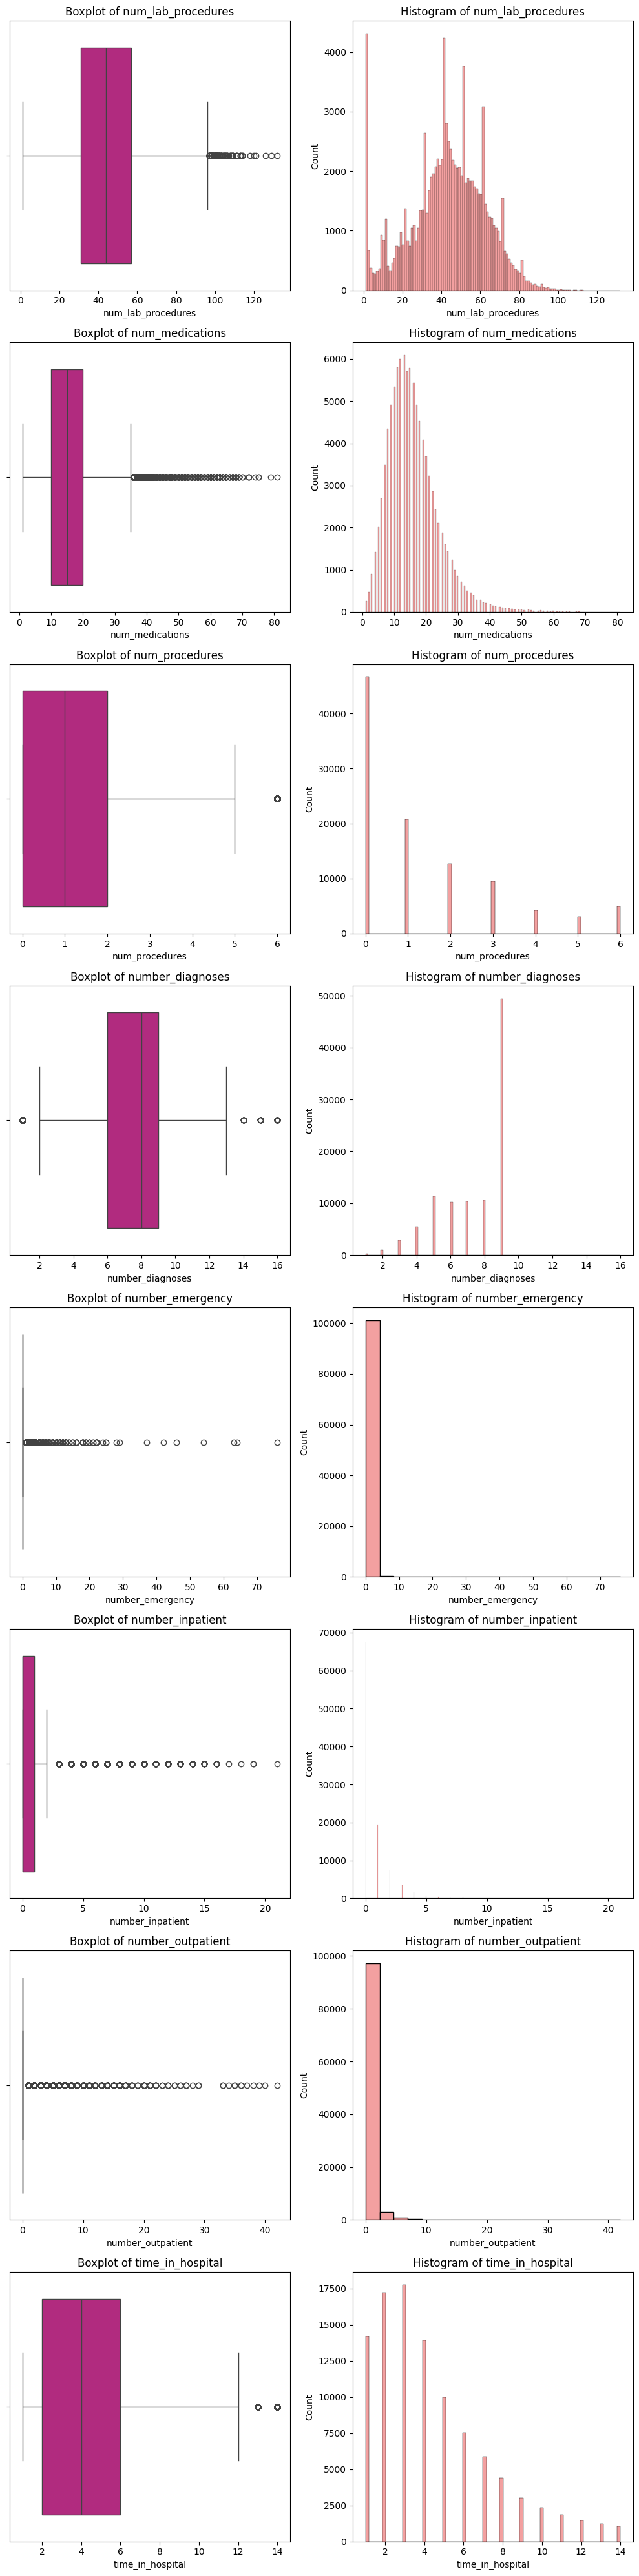

In [15]:
# analyze the distributions in the numeric data
plot_numeric_distributions(df)

In [16]:
def display_skewness_columns(df):
    """Generates a DataFrame analyzing columns' skewness.

    Args:
        df (pd.DataFrame): A dataset containing numeric data.

    Returns:
        pd.DataFrame: A DataFrame containing skewness values.
    """

    # check for skewness and rename columns
    skewness = df.select_dtypes(include="number").skew().reset_index()
    skewness.columns = ["column_name", "value"]

    # categorize the skewness
    conditions = [skewness["value"].abs().between(0.5, 1), skewness["value"].abs() > 1]
    choices = ["Moderate", "High"]
    skewness["skew_category"] = np.select(conditions, choices, default="Symmetric")

    # sort the values
    skewness.sort_values(by="value", ascending=False, inplace=True)

    return skewness

In [17]:
# create a DF showing skewness
display_skewness_columns(df)

,column_name,value,skew_category
5,number_emergency,22.855582,High
4,number_outpatient,8.832959,High
6,number_inpatient,3.614139,High
3,num_medications,1.326672,High
2,num_procedures,1.316415,High
0,time_in_hospital,1.133999,High
1,num_lab_procedures,-0.236544,Symmetric
7,number_diagnoses,-0.876746,Moderate


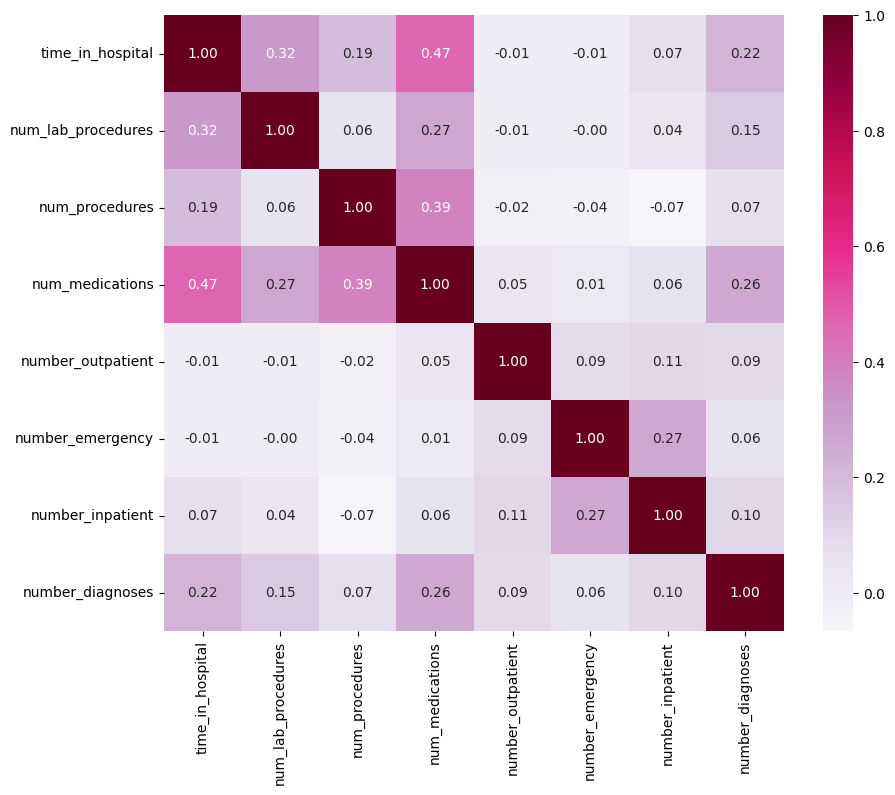

In [18]:
# analyze the strength of relationships among numeric columns
plt.figure(figsize=(10, 8))
corr_df = df.filter(regex=r"^(?!.*_(?:id|nbr)$)").corr(numeric_only=True)
sns.heatmap(corr_df, cmap="PuRd", annot=True, fmt=".2f")
plt.show()

### Explore categorical data <a class="anchor" id="eda_categorical"></a>

In [19]:
# look at descriptive statistics for categorical columns
df.describe(include="object")

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description,disease_class_1,disease_class_2,disease_class_3
count,101766,101766,99493,101766,101766,101766,101766,101766,101745,101408,...,101766,101766,101766,101766,101766,101766,101766,101745,101408,100343
unique,101766,71518,5,3,10,8,26,17,716,748,...,2,2,2,2,2,3,8,17,17,17
top,2278392,88785891,Caucasian,Female,[70-80),1,1,7,428,276,...,No,No,No,No,Yes,NO,Emergency | Discharged to home | Physician Re...,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System
freq,1,40,76099,54708,26068,53990,60234,57494,6862,6752,...,101765,101764,101765,54755,78363,54864,53990,30336,31365,29918


In [20]:
def display_cardinality_columns(df):
    """Generates a DataFrame analyzing columns' cardinality.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing cardinality statistics.
    """

    # get columns and their number of unique values
    cardinal_values = df.select_dtypes(include=["category", "object"]).nunique().reset_index()

    # rename the columns and categorize the skewness
    cardinal_values.columns = ["column_name", "num_unique"]
    cardinal_values["cardinality"] = cardinal_values["num_unique"].apply(lambda x: "Low" if x < 15 else "Moderate" if 15 <= x < 50 else "High")

    # sort the values
    cardinal_values.sort_values(by="num_unique", ascending=False, inplace=True)

    return cardinal_values

In [21]:
# create a DF showing cardinality
display_cardinality_columns(df)

,column_name,num_unique,cardinality
0,encounter_id,101766,High
1,patient_nbr,71518,High
10,diag_3,789,High
9,diag_2,748,High
8,diag_1,716,High
6,discharge_disposition_id,26,Moderate
39,disease_class_2,17,Moderate
38,disease_class_1,17,Moderate
40,disease_class_3,17,Moderate
7,admission_source_id,17,Moderate


In [22]:
def plot_categorical_distributions(df, threshold=5):
    """Generates a grid of violin and count plots for categorical columns.

    Args:
        df (pd.DataFrame): A dataset with categorical data.
        threshold (int): The max number of unique values a column should have.
    """

    # identify categorical columns and remove ID columns
    unique_values = df.select_dtypes(include=["category", "object"]).nunique()
    categorical_cols = sorted(unique_values[unique_values.values <= threshold].index)

    # get the number of categorical columns
    num_cols = len(categorical_cols)

    # create a figure and set of subplots
    fig, axes = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side violin plot and count plot for each row
    for i, col in enumerate(categorical_cols):

        sns.violinplot(data=df, x=col, color="mediumvioletred", ax=axes[i, 0])
        axes[i, 0].set_title(f"Boxplot of {col}")
        axes[i, 0].tick_params(axis="x", rotation=45)

        sns.countplot(data=df, x=col, color="lightcoral", ax=axes[i, 1])
        axes[i, 1].set_title(f"Histogram of {col}")
        axes[i, 1].tick_params(axis="x", rotation=45)

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()

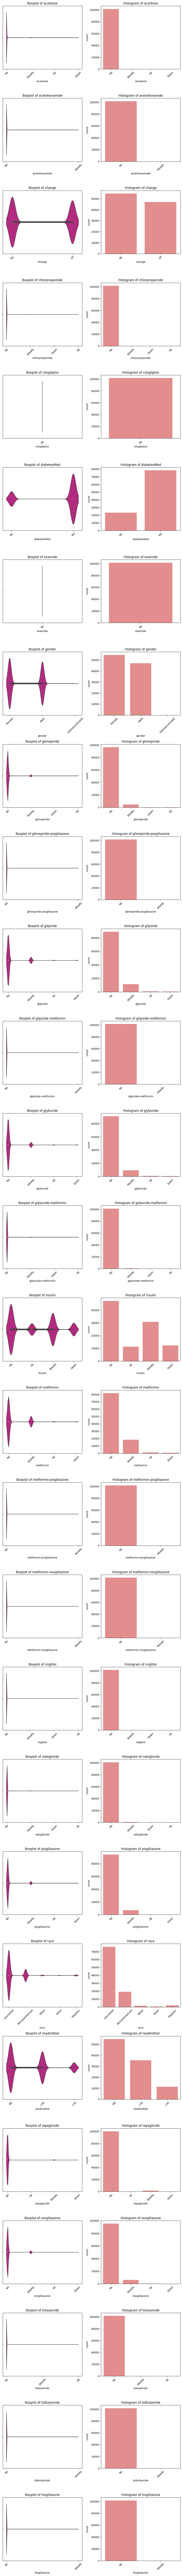

In [23]:
# analyze the distributions in the categorical data
plot_categorical_distributions(df)

In [24]:
def display_chi_square_columns(df, target_col):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset containing categorical columns.
        target_col (str): A variable that is being predicted on.

    Returns:
        pd.DataFrame: A DataFrame containing chi-square and p-value statistics.
    """

    # get categorical columns, except for identifier columns and the target
    categorical_cols = df.select_dtypes(include=["category", "object"]).columns
    categorical_df = df[categorical_cols].filter(regex=r"^(?!.*_(?:id|nbr)$)")
    categorical_df.drop(columns=target_col, inplace=True)

    # initialize a dictionary to hold the chi-square test results
    result_dict = {"column_name": [], "chi_sq": [], "p_val": []}

    for col in categorical_df:

        # compute the contingency table
        contingency_table = pd.crosstab(df[col], df[target_col])

        # computes the chi-square statistic and p-value
        chi_sq, p_val, _, _ = chi2_contingency(contingency_table)

        # append the results
        result_dict["column_name"].append(col)
        result_dict["chi_sq"].append(round(chi_sq, 2))
        result_dict["p_val"].append(round(p_val, 2))

    # create a DataFrame from the results
    result_df = pd.DataFrame(result_dict).sort_values(by="p_val")
    result_df["is_significant"] = result_df["p_val"] < 0.05

    print(f"Columns with/without a significant association to the column, {target_col}:")

    return result_df

In [25]:
display_chi_square_columns(df, "readmitted")

Columns with/without a significant association to the column, readmitted:


,column_name,chi_sq,p_val,is_significant
0,race,94.39,0.00,True
32,disease_class_1,834.35,0.00,True
31,description,415.76,0.00,True
30,diabetesMed,386.51,0.00,True
29,change,215.83,0.00,True
23,insulin,516.70,0.00,True
33,disease_class_2,559.51,0.00,True
16,rosiglitazone,43.01,0.00,True
15,pioglitazone,29.94,0.00,True
12,glipizide,54.26,0.00,True
